In [1]:
# load libraries
library(caret)
library(xgboost)
library(keras)
library(LiblineaR)
library(ROCR)
library(RColorBrewer)

Loading required package: lattice
Loading required package: ggplot2
Loading required package: gplots

Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



In [2]:
# load dataset
background.path <- "data/background.csv"
signal.path     <- "data/MC_signal.csv"
data_lhcb.path  <- "data/data_lhcb.csv"


background <- read.csv(background.path, row.names=1) # label 0
signal     <- read.csv(signal.path, row.names=1)     # label 1

data_lhcb  <- read.csv(data_lhcb.path, row.names=1)  # real data

In [3]:
# keep only significant features

features <- c("Lambda_c_MM_F",      # mass Lambda_c 
              "lc_p_ProbNNp_F",     # prob Lambda_c p identified as a p 
              "lcZDecLSigma_F",     # Lambda_c z decay length over error 
              "lcstarZDecLSigma_F", # Lambda_c* z decay length over error
              "lcDecTime_F",        # Lambda_c decay time
              "lcstarDecTime_F",    # Lambda_c* decay time
              "lbDecTime_F",        # Lambda_b decay time
              "lcDecVerChi2_F",     # prob of Lambda_c Chi2 vertex
              "lcstarDecVerChi2_F", # prob of Lambda_c* Chi2 vertex
              "Lambda_b0_DIRA_OWNPV_F", # Lambda_0 DIRA of PV
              "pair0_3pi_F",        # pair mass pi_0 and pi_1 
              "pair1_3pi_F"         # pair mass pi_1 and pi_2
             )

signal     <- signal[features]
background <- background[features]

data_lhcb  <- data_lhcb[features]


In [4]:
# separation of the dataset into train and test set
# 80% of the dataset is used for training

# signal
train.signal       <- signal[1:(as.integer(nrow(signal)*0.8)),]
train.label.signal <- replicate(nrow(train.signal),1)

test.signal        <- signal[(as.integer(nrow(signal)*0.8)+1):nrow(signal),]
test.label.signal  <- replicate(nrow(test.signal),1)

# background
train.background       <- background[1:(as.integer(nrow(background)*0.8)),]
train.label.background <- replicate(nrow(train.background),0)

test.background        <- background[(as.integer(nrow(background)*0.8)+1):nrow(background),]
test.label.background  <- replicate(nrow(test.background),0)

# final training and test set
train       <- rbind(train.signal,train.background)
train.label <- c(train.label.signal,train.label.background)
# shuffle data order in the training set
set.seed(20190630)
shuffle     <- sample(length(train.label))
train       <- train[shuffle,]
train.label <- train.label[shuffle]

test        <- rbind(test.signal,test.background)
test.label  <- c(test.label.signal,test.label.background)

# save the entire MC dataset to train the best model before making predictions on real data
MC          <- rbind(train, test)
MC.label    <- c(train.label, test.label)

#scaling data for feed the NN (mean=0, std=1)
train.scaled <- train %>% scale()
train.label  <- as.numeric(train.label)

test.scaled  <- test %>% scale()
test.label   <- as.numeric(test.label)

MC.scaled    <- MC %>% scale()
MC.label     <- as.numeric(MC.label)

# convert train, test and MC into matrix, as it is required for the analysis with xgboost package 
train <- as.matrix(train)
test  <- as.matrix(test)
MC    <- as.matrix(MC)


#str(train); str(train.label)
#str(test) ; str(test.label)


## Boosted Decision Tree

In [5]:
# fitting the best model with xgboost function using the entire MC dataset 

xgb_final <- xgb.train(nrounds          = 1500, 
                       eta              = 0.075,
                       max_depth        = 5, 
                       gamma            = 0.1,
                       colsample_bytree = 0.8, 
                       min_child_weight = 5,
                       subsample        = 1, 
                       data             = xgb.DMatrix(data = train, label=train.label), 
                       verbose          = TRUE, 
                       objective        = "binary:logistic",
                       )

test.xgb.predict <- predict(xgb_final, as.matrix(test))


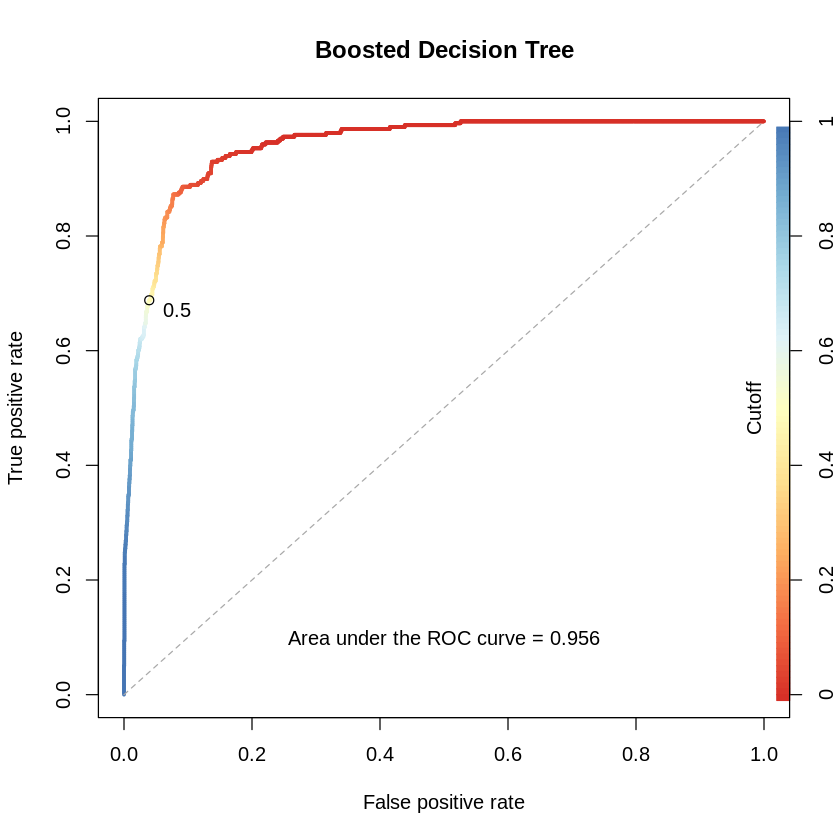

In [6]:
pred.xgb <- prediction(test.xgb.predict, test.label)
auc.xgb  <- performance(pred.xgb,measure="auc")
roc.xgb  <- performance(pred.xgb,"tpr","fpr")

plot(roc.xgb, main="Boosted Decision Tree", 
     colorize=TRUE, colorize.palette=colorRampPalette(brewer.pal(9,"RdYlBu"))(100),
     colorkey.relwidth=0.5, lwd=3, print.cutoffs.at=c(0.5), text.adj=c(-0.5,1.2))
text(0.5,0.1, paste0(auc.xgb@y.name, " = ",sprintf("%.3f", auc.xgb@y.values)))
mtext("Cutoff", side=4, line=-2)
lines(seq(from=0, to=1, by=0.01),seq(from=0, to=1, by=0.01), col="darkgray", lty=2)

In [7]:
pdf("Figure/BDT/roc.pdf")
plot(roc.xgb, main="Boosted Decision Tree", 
     colorize=TRUE, colorize.palette=colorRampPalette(brewer.pal(9,"RdYlBu"))(100),
     colorkey.relwidth=0.5, lwd=3, print.cutoffs.at=c(0.5), text.adj=c(-0.5,1.2))
text(0.5,0.1, paste0(auc.xgb@y.name, " = ",sprintf("%.3f", auc.xgb@y.values)))
mtext("Cutoff", side=4, line=-2)
lines(seq(from=0, to=1, by=0.01),seq(from=0, to=1, by=0.01), col="darkgray", lty=2)
dev.off()

png 
  2

## Neural Network

In [8]:
# building and training the best model on train set, and evaluate performance on the test set
model <- keras_model_sequential() 
model %>% 

    layer_dense(units = 10, input_shape = c(ncol(train.signal)), activation = "sigmoid") %>%
    layer_dense(units = 1, activation= "sigmoid")


model %>% compile(
    loss = "binary_crossentropy",
    optimizer = "Adam",
    metrics = 'accuracy'
)

history <- model %>% fit(
    train.scaled, 
    train.label,
    validation_data = list(test.scaled, test.label)
)

test.nn.predict <- model %>% predict(test.scaled)


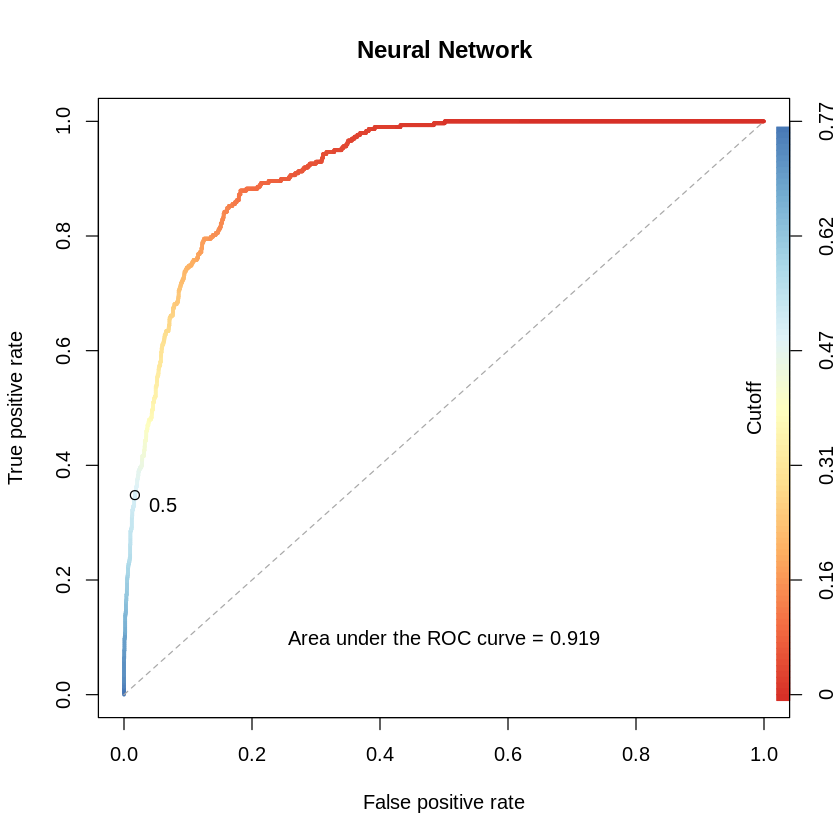

In [9]:
pred.nn <- prediction(test.nn.predict, test.label)
auc.nn  <- performance(pred.nn,measure="auc")
roc.nn  <- performance(pred.nn,"tpr","fpr")

plot(roc.nn, main="Neural Network", 
    colorize=TRUE, colorize.palette=colorRampPalette(brewer.pal(9,"RdYlBu"))(100),
    colorkey.relwidth=0.5, lwd=3, print.cutoffs.at=c(0.5), text.adj=c(-0.5,1.2))
text(0.5,0.1, paste0(auc.nn@y.name, " = ",sprintf("%.3f", auc.nn@y.values)))
mtext("Cutoff", side=4, line=-2)
lines(seq(from=0, to=1, by=0.01),seq(from=0, to=1, by=0.01), col="darkgray", lty=2)

In [10]:
pdf("Figure/NN/roc.pdf")
plot(roc.nn, main="Neural Network", 
    colorize=TRUE, colorize.palette=colorRampPalette(brewer.pal(9,"RdYlBu"))(100),
    colorkey.relwidth=0.5, lwd=3, print.cutoffs.at=c(0.5), text.adj=c(-0.5,1.2))
text(0.5,0.1, paste0(auc.nn@y.name, " = ",sprintf("%.3f", auc.nn@y.values)))
mtext("Cutoff", side=4, line=-2)
lines(seq(from=0, to=1, by=0.01),seq(from=0, to=1, by=0.01), col="darkgray", lty=2)
dev.off()

png 
  2

## Logistic Regression

In [11]:
logistic_final <- LiblineaR(data=train, target=train.label, 
                            type=6,
                            cost=0.6,
                            epsilon=0.01
                           )
test.log.predict <- as.numeric(predict(logistic_final, test, proba=T)$probabilities[,1])

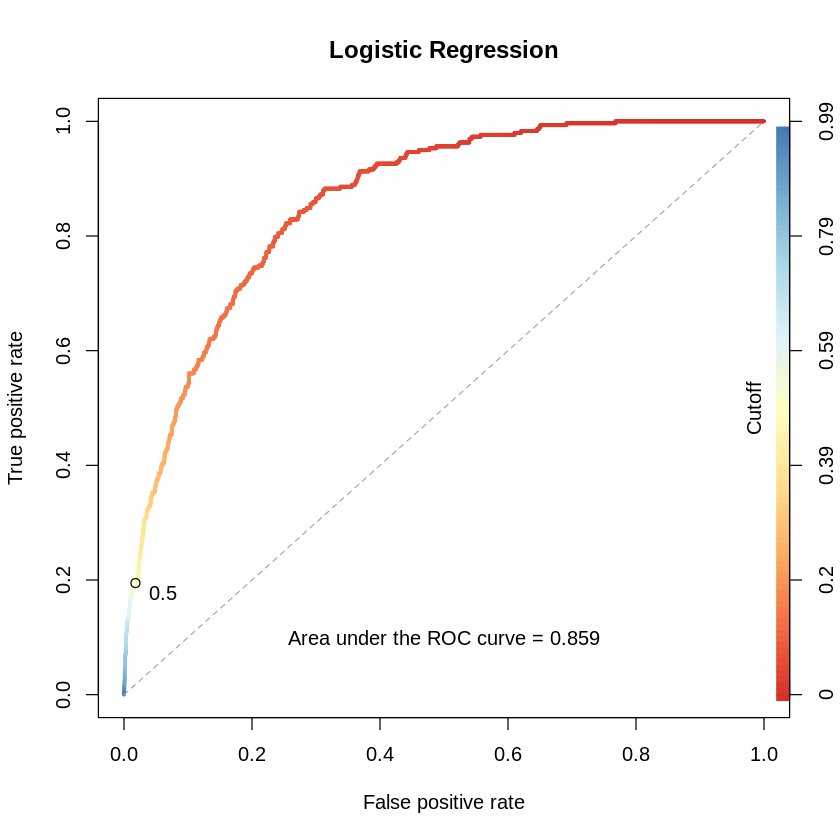

In [12]:
pred.log <- prediction(test.log.predict, test.label)
auc.log  <- performance(pred.log,measure="auc")
roc.log  <- performance(pred.log,"tpr","fpr")

plot(roc.log, main="Logistic Regression", 
     colorize=TRUE, colorize.palette=colorRampPalette(brewer.pal(9,"RdYlBu"))(100),
     colorkey.relwidth=0.5, lwd=3, print.cutoffs.at=c(0.5), text.adj=c(-0.5,1.2))
text(0.5,0.1, paste0(auc.log@y.name, " = ",sprintf("%.3f", auc.log@y.values)))
mtext("Cutoff", side=4, line=-2)
lines(seq(from=0, to=1, by=0.01),seq(from=0, to=1, by=0.01), col="darkgray", lty=2)

In [13]:
pred.log <- prediction(test.log.predict, test.label)
auc.log  <- performance(pred.log,measure="auc")
roc.log  <- performance(pred.log,"tpr","fpr")

pdf("Figure/Logistic/roc.pdf")
plot(roc.log, main="Logistic Regression", 
     colorize=TRUE, colorize.palette=colorRampPalette(brewer.pal(9,"RdYlBu"))(100),
     colorkey.relwidth=0.5, lwd=3, print.cutoffs.at=c(0.5), text.adj=c(-0.5,1.2))
text(0.5,0.1, paste0(auc.log@y.name, " = ",sprintf("%.3f", auc.log@y.values)))
mtext("Cutoff", side=4, line=-2)
lines(seq(from=0, to=1, by=0.01),seq(from=0, to=1, by=0.01), col="darkgray", lty=2)
dev.off()

png 
  2